# Testing
* This notbook include functions and plotting scripts to depict testing results on best trained model

## Processing dataset and storing test results

In [16]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [41]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
# Load a model
model = YOLO('yolo_output_models/working/runs/classify/train/weights/best.pt')

In [46]:
def analyze_food(image, model):
    """Analyze food image and return prediction (for use in a Jupyter notebook)."""
    try:
        # Resize image to the desired size
        image = Image.open(image_path).convert('RGB')
        image_resized = image.resize((640, 640))
        
        # Run the model on the image
        results = model(image)
        
        # Ensure results are available and non-empty
        if results and len(results) > 0:
            result = results[0]
            probs = getattr(result, 'probs', None)
            
            # If probability data is available, extract top prediction and confidence
            if probs is not None:
                prediction = result.names[probs.top1]
                confidence = float(probs.top1conf)
                return prediction, confidence
        
        # If no valid prediction was found
        return None, 0.0
    
    except Exception as e:
        # Print error to notebook output
        print(f"Error analyzing image: {str(e)}")
        return None, 0.0

In [49]:
# Example of using the function
image_path = 'Dataset/FOOD_data/test/apple_pie/67826.jpg'
prediction, confidence = analyze_food(image_path,model)
print(f"Prediction: {prediction}, Confidence: {confidence:.2f}")

# # Optional: Display the image
# image = Image.open(image_path)
# plt.imshow(image)
# plt.title(f"Predicted: {prediction} with confidence {confidence:.2f}")
# plt.show()


0: 640x640 apple_pie 0.97, baklava 0.03, garlic_bread 0.00, pancakes 0.00, cheesecake 0.00, 215.9ms
Speed: 14.3ms preprocess, 215.9ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Prediction: apple_pie, Confidence: 0.97


In [50]:
import os
import csv
from PIL import Image

# Path to your test dataset folder
test_folder = 'Dataset/FOOD_data/test'
# Output CSV file name
csv_file_path = 'predictions.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['actual', 'predicted'])
    
    # Walk through the test folder
    for root, dirs, files in os.walk(test_folder):
        # Extract the actual label (folder name)
        actual_label = os.path.basename(root)
        
        # Skip the root directory if it's not a class folder
        # (This assumes that the directory structure is strictly test/class_name/images)
        if actual_label == 'test':
            continue
        
        # Iterate over each file (image) in the folder
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                prediction, confidence = analyze_food(image_path, model)
                
                # Write the actual label and predicted label to the CSV
                writer.writerow([actual_label, prediction])

print("Prediction CSV file created successfully!")


0: 640x640 foie_gras 1.00, scallops 0.00, pork_chop 0.00, grilled_salmon 0.00, creme_brulee 0.00, 284.0ms
Speed: 13.3ms preprocess, 284.0ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 foie_gras 0.75, pork_chop 0.16, filet_mignon 0.06, steak 0.02, grilled_salmon 0.00, 156.3ms
Speed: 4.6ms preprocess, 156.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 foie_gras 0.85, scallops 0.15, steak 0.00, pork_chop 0.00, gnocchi 0.00, 141.7ms
Speed: 4.0ms preprocess, 141.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 foie_gras 0.93, lobster_bisque 0.02, tiramisu 0.02, creme_brulee 0.01, beef_carpaccio 0.00, 162.3ms
Speed: 3.9ms preprocess, 162.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 cheese_plate 0.71, chocolate_mousse 0.12, chocolate_cake 0.10, carrot_cake 0.01, panna_cotta 0.01, 233.3ms
Speed: 6.1ms preprocess, 233.3ms inference, 0.0ms postprocess per image 

## Test set analysis and visualizations

In [53]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [51]:
# Load your predictions.csv
df = pd.read_csv('predictions.csv')  # Assuming the file has 'actual' and 'predicted' columns

# 1. Check the first few rows
print(df.head())

      actual     predicted
0  foie_gras     foie_gras
1  foie_gras     foie_gras
2  foie_gras     foie_gras
3  foie_gras     foie_gras
4  foie_gras  cheese_plate


In [52]:
df.shape

(14527, 2)

In [54]:
# 2. Calculate overall accuracy
overall_accuracy = (df['actual'] == df['predicted']).mean()
print(f"Overall Accuracy: {overall_accuracy:.2f}")

Overall Accuracy: 0.87


In [55]:
# 3. Per-category counts and accuracy
# Group by actual category to see how many images per category
category_counts = df.groupby('actual').size().reset_index(name='count')
print("\nImages per category (actual):")
print(category_counts)


Images per category (actual):
             actual  count
0         apple_pie    148
1    baby_back_ribs    148
2           baklava    149
3    beef_carpaccio    141
4      beef_tartare    144
..              ...    ...
96            tacos    148
97         takoyaki    148
98         tiramisu    147
99     tuna_tartare    150
100         waffles    147

[101 rows x 2 columns]


In [56]:
# Calculate per-category accuracy
# For each category, count how many times predicted == actual
correct_counts = df[df['actual'] == df['predicted']].groupby('actual').size().reset_index(name='correct')
per_cat = pd.merge(category_counts, correct_counts, on='actual', how='left').fillna(0)
per_cat['accuracy'] = per_cat['correct'] / per_cat['count']
print("\nPer-category Accuracy:")
print(per_cat)


Per-category Accuracy:
             actual  count  correct  accuracy
0         apple_pie    148      113  0.763514
1    baby_back_ribs    148      129  0.871622
2           baklava    149      136  0.912752
3    beef_carpaccio    141      130  0.921986
4      beef_tartare    144      125  0.868056
..              ...    ...      ...       ...
96            tacos    148      130  0.878378
97         takoyaki    148      140  0.945946
98         tiramisu    147      128  0.870748
99     tuna_tartare    150      106  0.706667
100         waffles    147      132  0.897959

[101 rows x 4 columns]


In [57]:
# 4. Generate a confusion matrix
categories = sorted(df['actual'].unique())
cm = confusion_matrix(df['actual'], df['predicted'], labels=categories)
cm_df = pd.DataFrame(cm, index=categories, columns=categories)

print("\nConfusion Matrix:")
print(cm_df)


Confusion Matrix:
                apple_pie  baby_back_ribs  baklava  beef_carpaccio  \
apple_pie             113               0        5               0   
baby_back_ribs          0             129        0               0   
baklava                 1               0      136               0   
beef_carpaccio          0               0        0             130   
beef_tartare            0               0        0               2   
...                   ...             ...      ...             ...   
tacos                   0               0        0               0   
takoyaki                0               0        0               0   
tiramisu                0               0        0               0   
tuna_tartare            0               0        0               1   
waffles                 1               0        0               0   

                beef_tartare  beet_salad  beignets  bibimbap  bread_pudding  \
apple_pie                  0           0         0         1 

In [58]:
# If you want a normalized confusion matrix (percentages), you can do:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm_df = pd.DataFrame(cm_normalized, index=categories, columns=categories)
print("\nNormalized Confusion Matrix (per row):")
print(cm_norm_df)


Normalized Confusion Matrix (per row):
                apple_pie  baby_back_ribs   baklava  beef_carpaccio  \
apple_pie        0.763514        0.000000  0.033784        0.000000   
baby_back_ribs   0.000000        0.871622  0.000000        0.000000   
baklava          0.006711        0.000000  0.912752        0.000000   
beef_carpaccio   0.000000        0.000000  0.000000        0.921986   
beef_tartare     0.000000        0.000000  0.000000        0.013889   
...                   ...             ...       ...             ...   
tacos            0.000000        0.000000  0.000000        0.000000   
takoyaki         0.000000        0.000000  0.000000        0.000000   
tiramisu         0.000000        0.000000  0.000000        0.000000   
tuna_tartare     0.000000        0.000000  0.000000        0.006667   
waffles          0.006803        0.000000  0.000000        0.000000   

                beef_tartare  beet_salad  beignets  bibimbap  bread_pudding  \
apple_pie           0.000000

In [59]:
# 5. Classification report for precision, recall, and F1-score per category
print("\nClassification Report:")
report = classification_report(df['actual'], df['predicted'], target_names=categories)
print(report)


Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.78      0.76      0.77       148
         baby_back_ribs       0.86      0.87      0.87       148
                baklava       0.92      0.91      0.92       149
         beef_carpaccio       0.94      0.92      0.93       141
           beef_tartare       0.80      0.87      0.83       144
             beet_salad       0.87      0.88      0.88       149
               beignets       0.87      0.94      0.90       144
               bibimbap       0.94      0.96      0.95       142
          bread_pudding       0.72      0.71      0.72       148
      breakfast_burrito       0.90      0.88      0.89       148
             bruschetta       0.82      0.86      0.84       142
           caesar_salad       0.87      0.89      0.88       145
                cannoli       0.94      0.93      0.93       148
          caprese_salad       0.91      0.89      0.90       147


/var/folders/2_/6f0pjncx2gxbv5z61bz_4l8c0000gn/T/ipykernel_55734/4248698411.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_f1, x=metric, y='category', ax=ax, palette='Blues_r')
/var/folders/2_/6f0pjncx2gxbv5z61bz_4l8c0000gn/T/ipykernel_55734/4248698411.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_f1, x=metric, y='category', ax=ax, palette='Blues_r')
/var/folders/2_/6f0pjncx2gxbv5z61bz_4l8c0000gn/T/ipykernel_55734/4248698411.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_f1, x=metric, y=

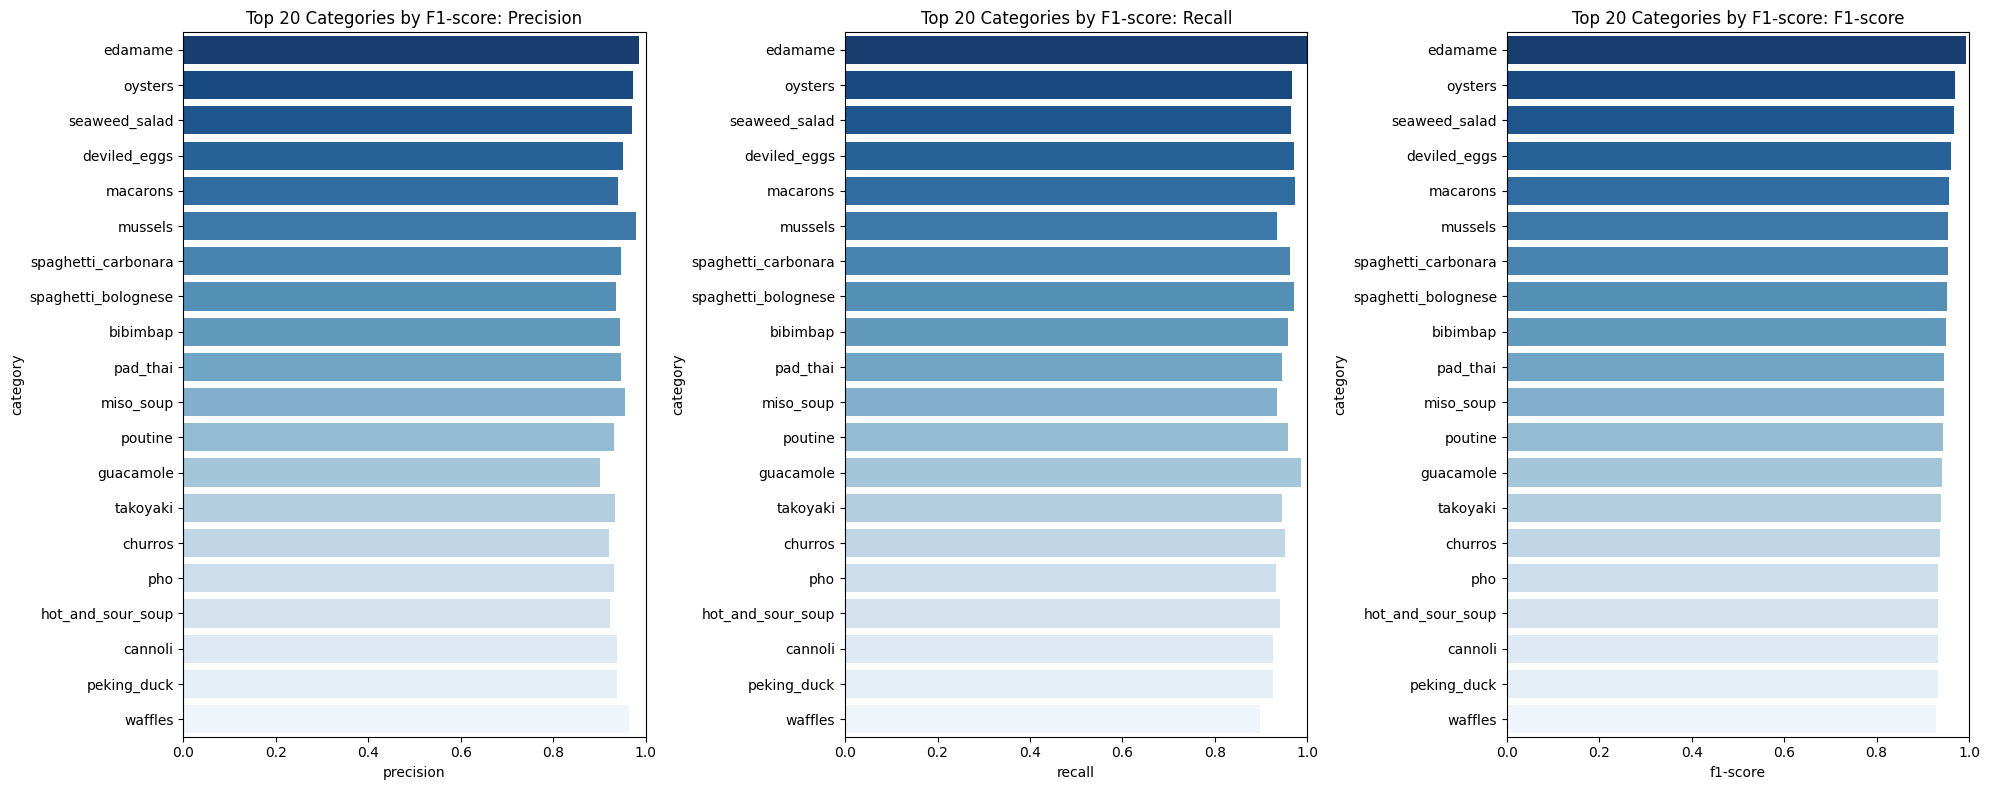

/var/folders/2_/6f0pjncx2gxbv5z61bz_4l8c0000gn/T/ipykernel_55734/4248698411.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_20_f1, x=metric, y='category', ax=ax, palette='Reds_r')
/var/folders/2_/6f0pjncx2gxbv5z61bz_4l8c0000gn/T/ipykernel_55734/4248698411.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_20_f1, x=metric, y='category', ax=ax, palette='Reds_r')
/var/folders/2_/6f0pjncx2gxbv5z61bz_4l8c0000gn/T/ipykernel_55734/4248698411.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_20_f1, x=met

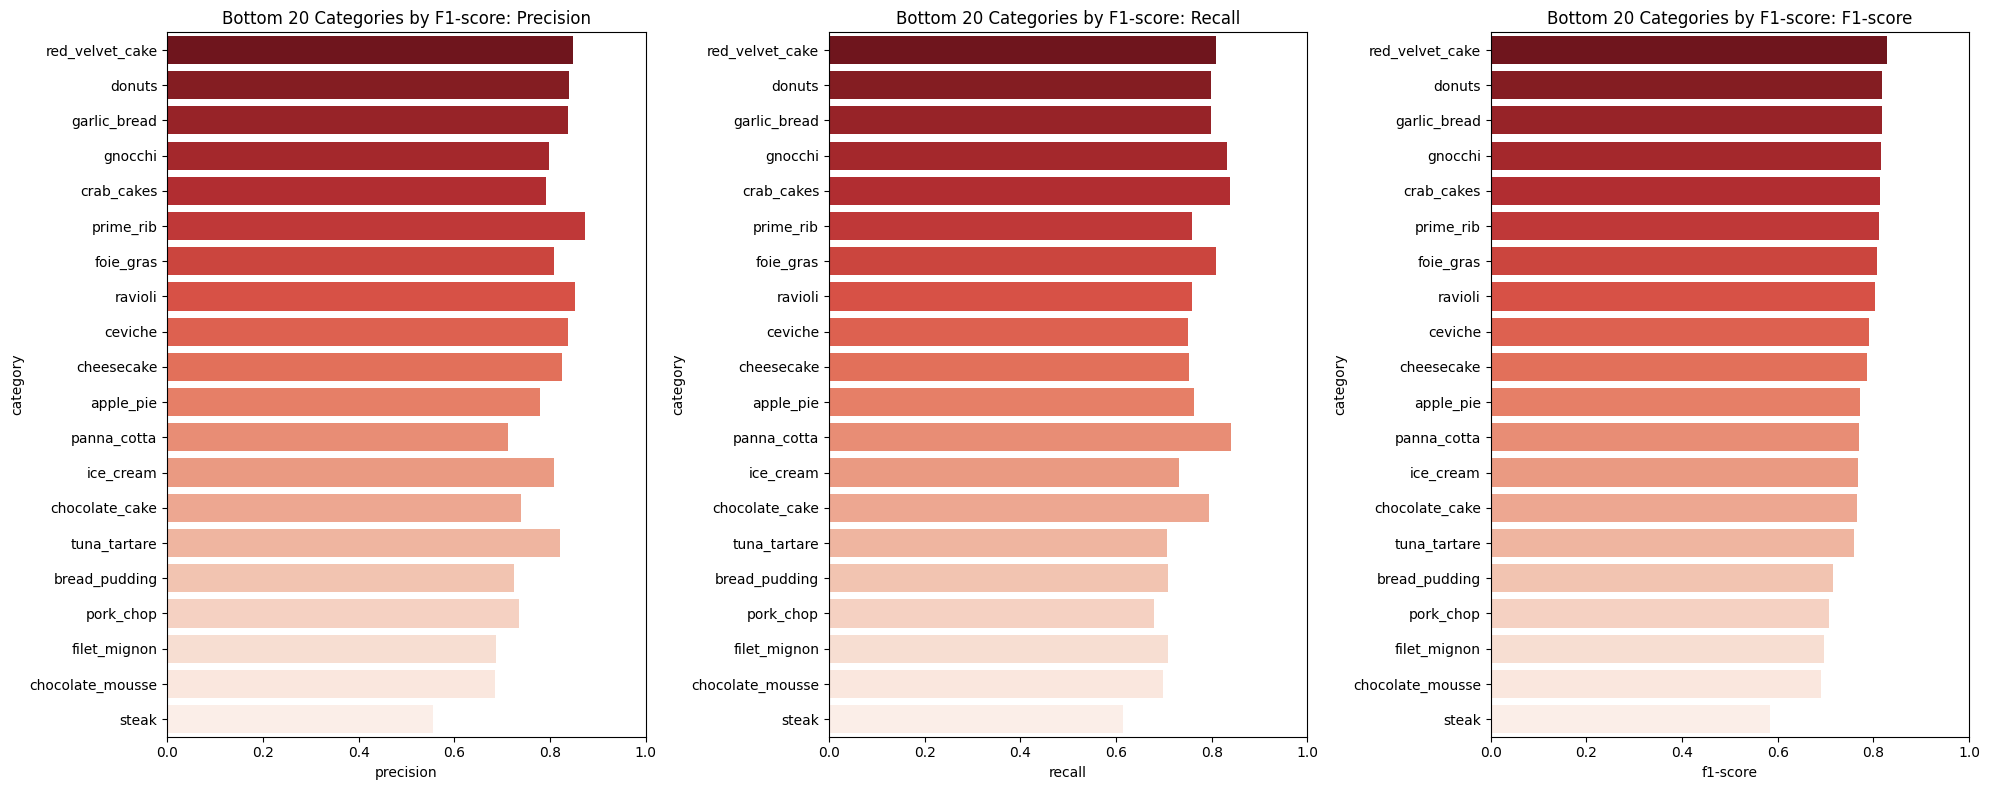

/var/folders/2_/6f0pjncx2gxbv5z61bz_4l8c0000gn/T/ipykernel_55734/4248698411.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_acc, x='accuracy', y='actual', palette='Greens_r')


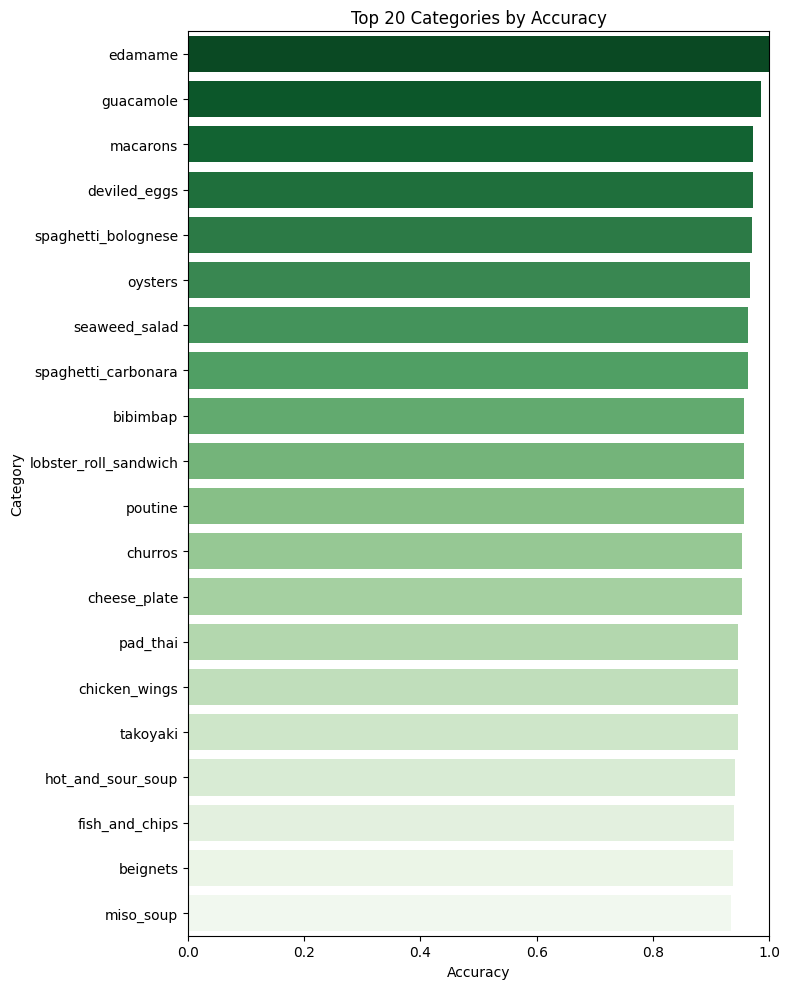

/var/folders/2_/6f0pjncx2gxbv5z61bz_4l8c0000gn/T/ipykernel_55734/4248698411.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_20_acc, x='accuracy', y='actual', palette='Oranges_r')


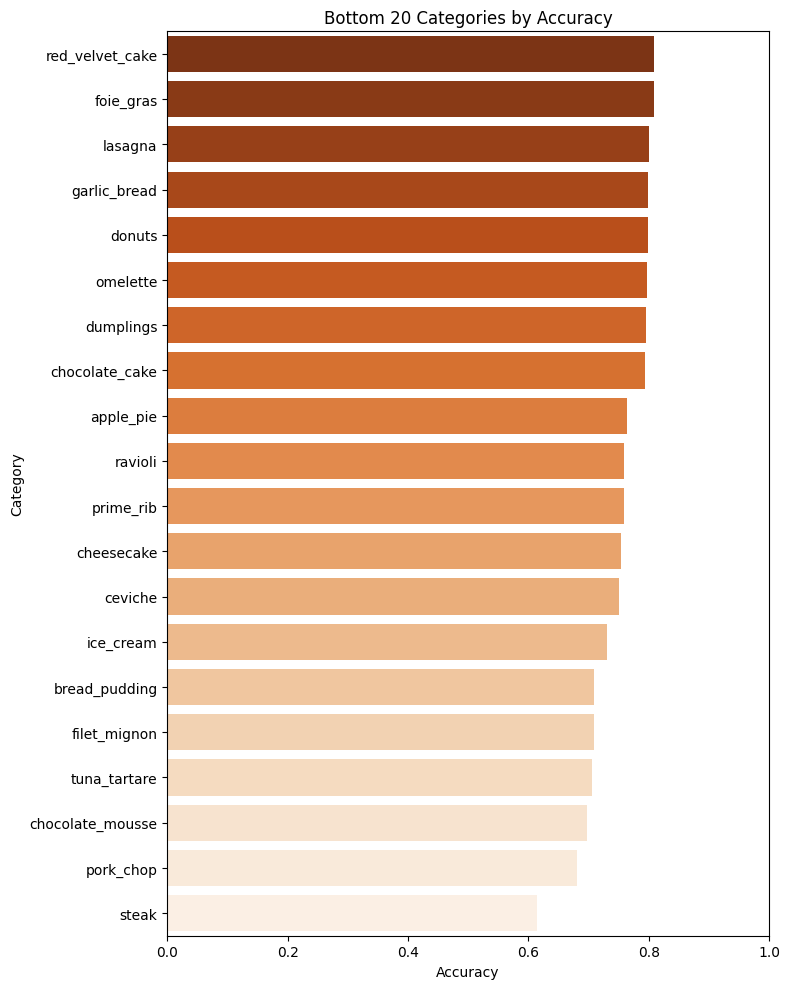

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assume we already have:
# df with 'actual' and 'predicted'

categories = sorted(df['actual'].unique())

# Create classification report DataFrame
report = classification_report(df['actual'], df['predicted'], target_names=categories, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Exclude the last three rows (avg/total metrics)
metrics_df = report_df.iloc[:-3]  # all categories only

# Create per-category accuracy DataFrame
category_counts = df.groupby('actual').size().reset_index(name='count')
correct_counts = df[df['actual'] == df['predicted']].groupby('actual').size().reset_index(name='correct')
per_cat = pd.merge(category_counts, correct_counts, on='actual', how='left').fillna(0)
per_cat['accuracy'] = per_cat['correct'] / per_cat['count']

# Convert index to column for merging/plotting convenience
metrics_df = metrics_df.reset_index().rename(columns={'index': 'category'})

# Let's say we sort by F1-score, you can also choose another metric
sort_metric = 'f1-score'

# Sort categories by chosen metric
metrics_sorted = metrics_df.sort_values(by=sort_metric, ascending=False)
top_20_f1 = metrics_sorted.head(20)
bottom_20_f1 = metrics_sorted.tail(20)

# Plot Precision, Recall, F1-score for top 20 categories
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
metrics = ['precision', 'recall', 'f1-score']
for ax, metric in zip(axes, metrics):
    sns.barplot(data=top_20_f1, x=metric, y='category', ax=ax, palette='Blues_r')
    ax.set_title(f"Top 20 Categories by {sort_metric.capitalize()}: {metric.capitalize()}")
    ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

# Plot Precision, Recall, F1-score for bottom 20 categories
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for ax, metric in zip(axes, metrics):
    sns.barplot(data=bottom_20_f1, x=metric, y='category', ax=ax, palette='Reds_r')
    ax.set_title(f"Bottom 20 Categories by {sort_metric.capitalize()}: {metric.capitalize()}")
    ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

# Now do the same for accuracy in per_cat
per_cat_sorted = per_cat.sort_values('accuracy', ascending=False)
top_20_acc = per_cat_sorted.head(20)
bottom_20_acc = per_cat_sorted.tail(20)

# Plot top 20 categories by accuracy
plt.figure(figsize=(8, 10))
sns.barplot(data=top_20_acc, x='accuracy', y='actual', palette='Greens_r')
plt.title("Top 20 Categories by Accuracy")
plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# Plot bottom 20 categories by accuracy
plt.figure(figsize=(8, 10))
sns.barplot(data=bottom_20_acc, x='accuracy', y='actual', palette='Oranges_r')
plt.title("Bottom 20 Categories by Accuracy")
plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

## Model training output graphs

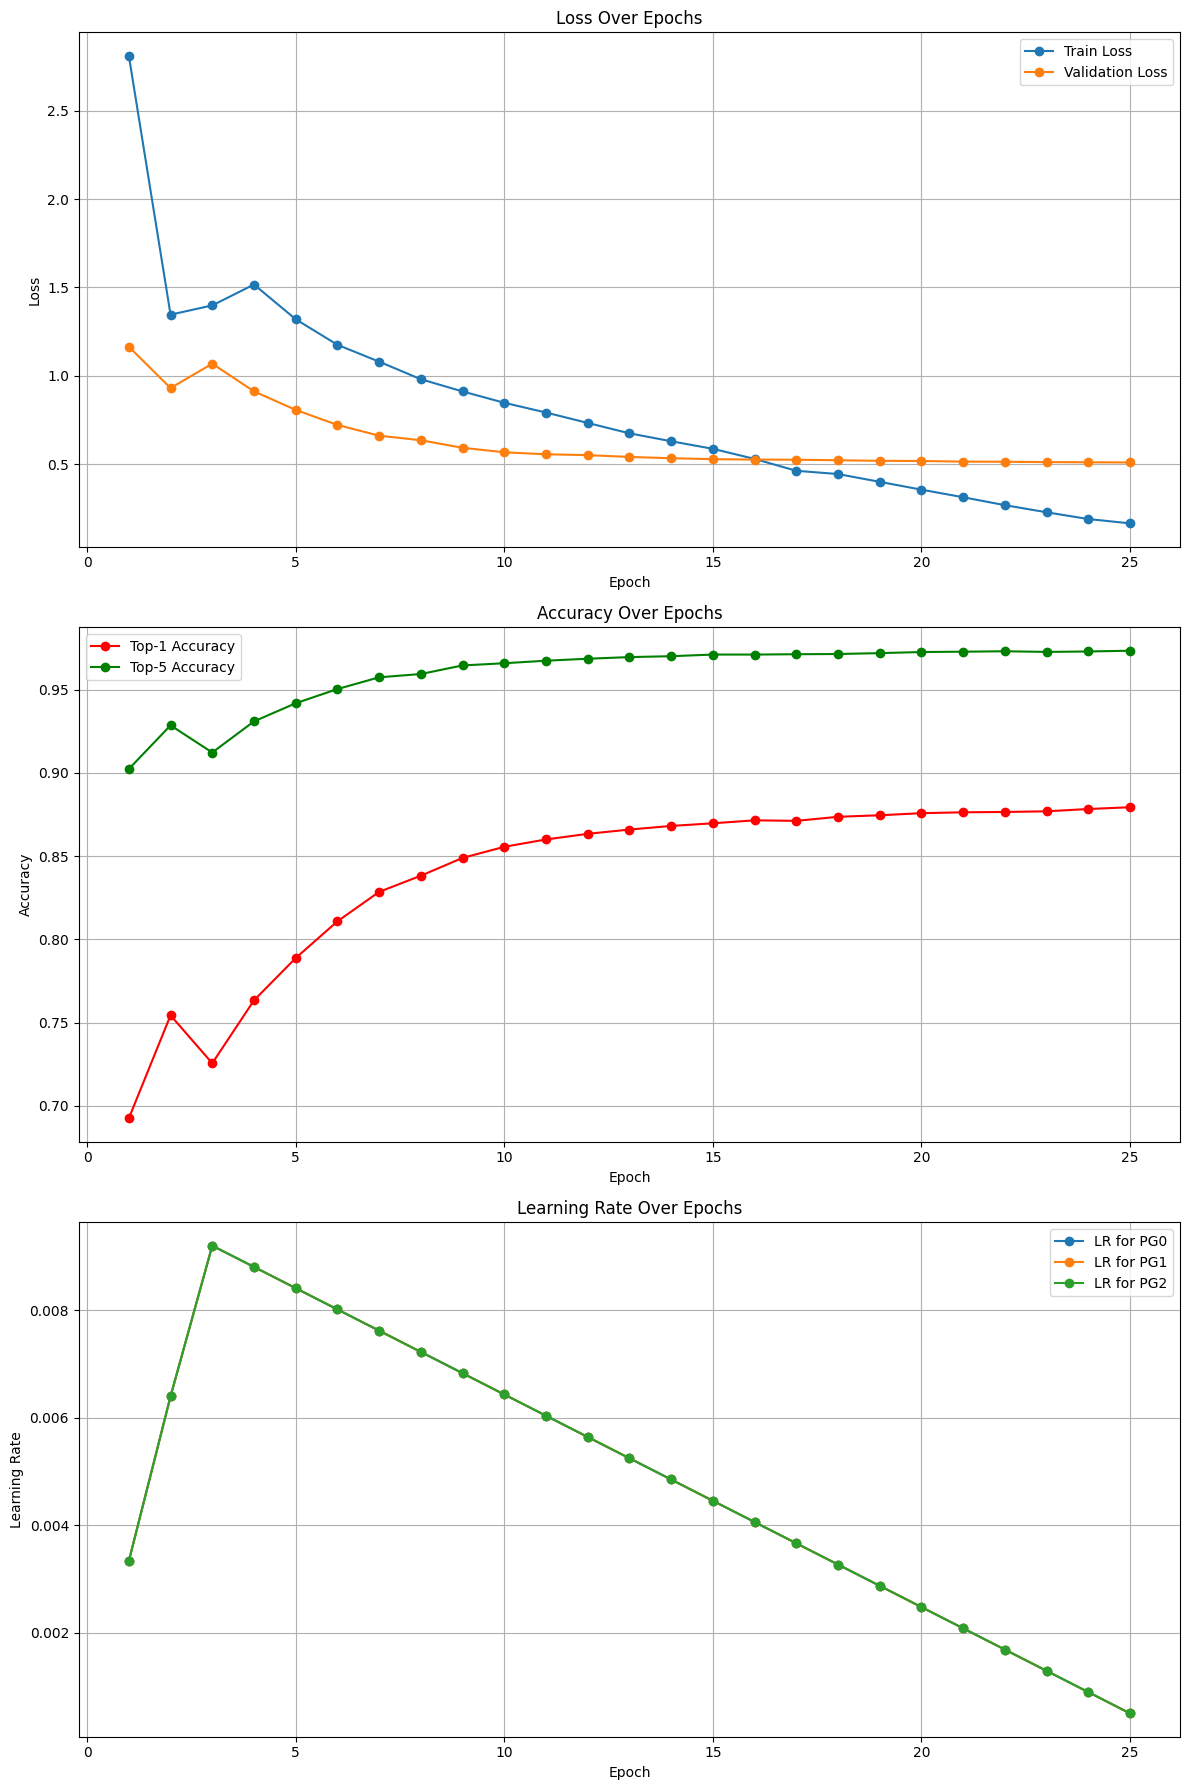

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
data = pd.read_csv('yolo_output_models/working/runs/classify/train/results.csv')

# Setting up the figure and axes for subplots
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Plot Loss over epochs
ax[0].plot(data['epoch'], data['train/loss'], label='Train Loss', marker='o')
ax[0].plot(data['epoch'], data['val/loss'], label='Validation Loss', marker='o')
ax[0].set_title('Loss Over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# Plot Accuracy over epochs
ax[1].plot(data['epoch'], data['metrics/accuracy_top1'], label='Top-1 Accuracy', color='r', marker='o')
ax[1].plot(data['epoch'], data['metrics/accuracy_top5'], label='Top-5 Accuracy', color='g', marker='o')
ax[1].set_title('Accuracy Over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

# Plot Learning rate over epochs for each parameter group
ax[2].plot(data['epoch'], data['lr/pg0'], label='LR for PG0', marker='o')
ax[2].plot(data['epoch'], data['lr/pg1'], label='LR for PG1', marker='o')
ax[2].plot(data['epoch'], data['lr/pg2'], label='LR for PG2', marker='o')
ax[2].set_title('Learning Rate Over Epochs')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Learning Rate')
ax[2].legend()
ax[2].grid(True)

# Display the plots
plt.tight_layout()
plt.show()